Анастасия Плавина

## Модель предсказания невыполнения клиентом долговых обязательств

**Цель проекта**: обучить модель предсказания невыполнения долговых обязательств клиентом по текущему кредиту на основе данных о клиенте банка.

**Метрика качества**: F1-score - метрика, показывающая гармоническое среднее между показателями precision и recall. В качестве baseline принимается значение 0.5

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from sklearn.metrics import f1_score, precision_recall_curve, plot_precision_recall_curve, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import Pool

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

%matplotlib inline

### 1. Обзор датасета

**Целевая переменная**
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)



**Независимые переменные:**
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка кредитоспособности


### 2. Загрузка данных

In [2]:
train_path = 'course_project_train.csv'
test_path = 'course_project_test.csv'

In [3]:
df = pd.read_csv(train_path)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


In [4]:
df.shape

(7500, 17)

In [5]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### 3. Обзор целевой переменной

In [6]:
target_name = 'Credit Default'
features_names = df.columns.drop(target_name).tolist()

Соотношение целевой переменной
0 (погашение) - 72%
1 (просрочка) - 28%


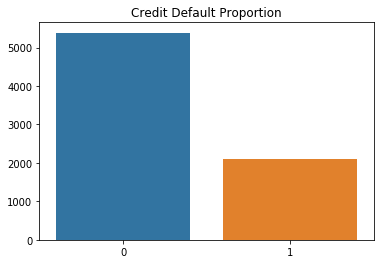

In [7]:
counts = df[target_name].value_counts()

print('Соотношение целевой переменной')
print(f'0 (погашение) - {counts[0]/df.shape[0]*100:.0f}%')
print(f'1 (просрочка) - {counts[1]/df.shape[0]*100:.0f}%')


plt.figure(figsize=(6,4))    
plt.title('Credit Default Proportion')
sns.barplot(counts.index, counts.values)
plt.show()

### 4. Обзор признаков

In [8]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [9]:
target_name = 'Credit Default'
cat_feature_names = ['Home Ownership', 'Years in current job', 'Bankruptcies', 'Number of Credit Problems', 
                     'Purpose', 'Term', 'Tax Liens']

num_feature_names = ['Annual Income','Number of Open Accounts','Years of Credit History', 
                     'Maximum Open Credit','Months since last delinquent',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

#### 4.1 Категориальные признаки

In [10]:
# for cat_colname in cat_feature_names:
#     print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
#     counts = df[cat_colname].value_counts()
#     plt.figure(figsize=(10,4))    
#     plt.title(cat_colname)
#     plt.xticks(rotation=90)
#     sns.barplot(counts.index, counts.values)
#     plt.show()

#### 4.2. Количественные признаки

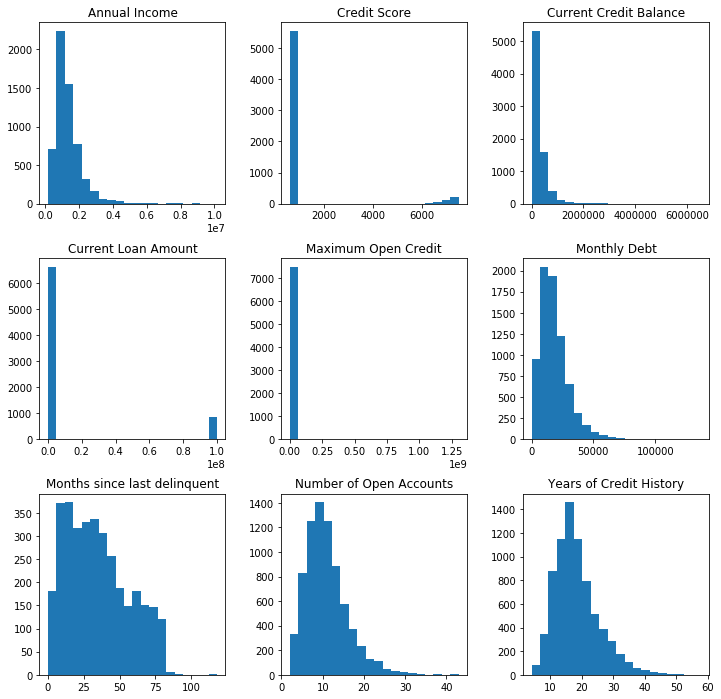

In [11]:
df[num_feature_names].hist(figsize=(12,12), bins=20, grid=False)
plt.show()

#### 4.3. Обзор пропусков

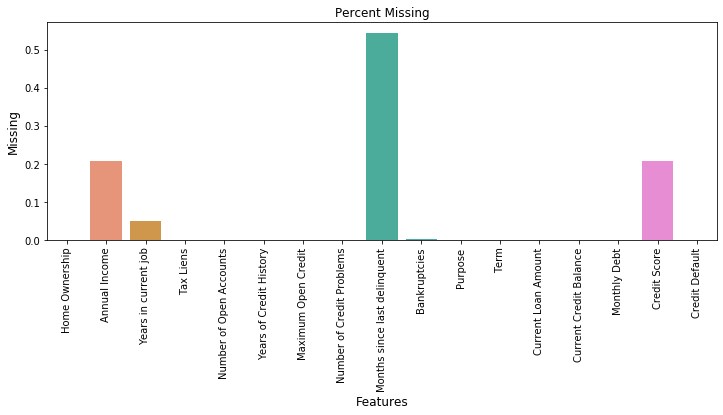

In [12]:
nan_df = (df.isna().sum() / df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(12,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

### 5. Обработка пропусков и выбросов

In [13]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        self.modes=None
        
    def fit(self, X):
        # задаем медианы по тренировочному датасету X
        self.medians = X.median()
        self.modes = X.mode()
            
    def transform(self, X):
        
        ## Обработка пропусков
        # для клиентов, у которых не было проблем по кредиту, заполняем на -1 пропуски в Months since last delinquent
        # заполняем пропуски в Bankruptcies нулями, если не было проблем по кредиту
        
        
        # Months since last delinquent  
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = \
                                        self.modes['Months since last delinquent'][0]
        
        # Bankruptcies
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.modes['Bankruptcies'][0]
        X.loc[X['Bankruptcies'] > 2, 'Bankruptcies'] = self.modes['Bankruptcies'][0]
        
        
        # Number of Credit Problems
        X.loc[X['Number of Credit Problems'] > 3, 'Number of Credit Problems'] =  \
                                        self.modes['Number of Credit Problems'][0]
        
        
        # Tax Liens
        X.loc[X['Tax Liens'] > 2, 'Tax Liens'] = self.modes['Tax Liens'][0]
        
        
        
        # Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = self.modes['Home Ownership'][0]
        
        
        # Term
        X.loc[X['Term'].isna(), 'Term'] = self.modes['Term'][0]


        # Annual Income
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        # Years in current job
        X.loc[X['Years in current job'].isna(), 'Years in current job'] =  \
                                        self.modes['Years in current job'][0]
        
        # Credit Score
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']

    
        ## Обработка выборосов       
        X.loc[X['Current Loan Amount'] >= 99999999.0, 'Current Loan Amount'] = 1000000
        X.loc[X['Credit Score'] > 850, 'Credit Score'] /= 10
        

        return X

In [14]:
# преобразовываем исходный датасет для проверки гипотез
imputer = FeatureImputer()

imputer.fit(df)

df = imputer.transform(df)

### 6. Проверка гипотез и отбор признаков

#### 6.1. Поиск корреляций

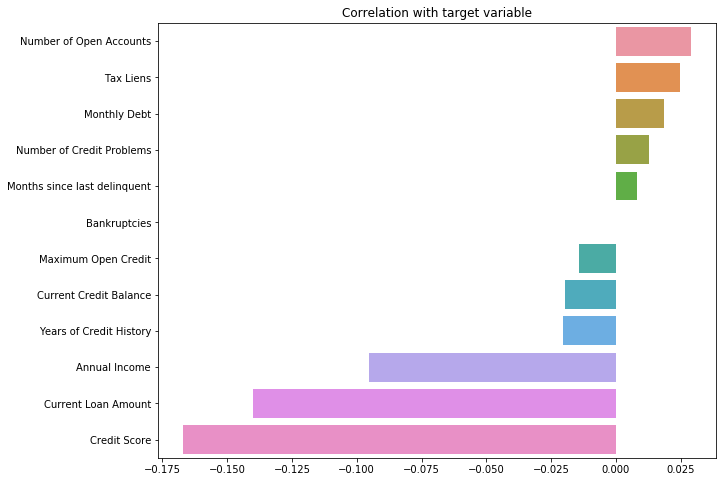

In [15]:
corr_with_target = df[features_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

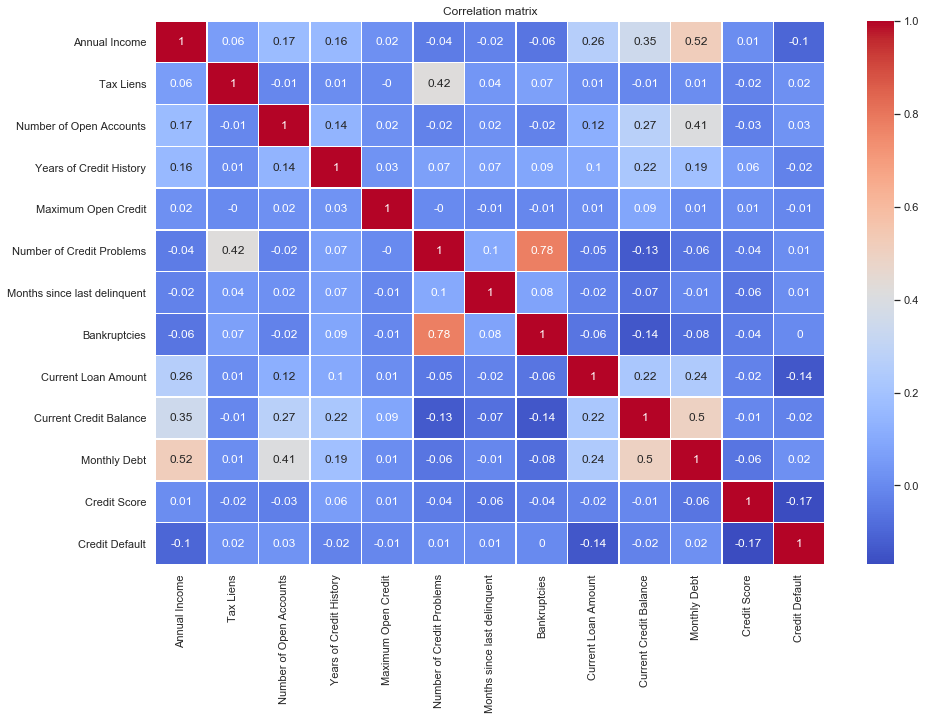

In [16]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1)


corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Выводы по корреляционной матрице:**

1. Наблюдается наибольшая корреляция таргета с показателем Credit Score.
2. Количество ситуаций, когда клиент объявляет о банкротстве, коррелирует с количеством проблем по кредиту.
3. Количество проблем по кредитам, в свою очередь, коррелирует с уровнем налоговых обременений.
4. Месячный долг демонстрирует корреляцию с годовым доходом, количеством открытых счетов и текущим остатком по кредиту.

#### 6.2 Проверка гипотез о категиориальных признаках

In [17]:
# for name in cat_feature_names:

#     plt.figure(figsize=(10, 8))

#     sns.countplot(x=name, hue=target_name, data=df)
#     plt.title(f'{name} grouped by target variable')
#     plt.legend(title='Target', loc='upper right')

#     plt.show()

In [18]:
def contingency_test(df, feature):
    feat_values = df[feature].unique()

    for item in itertools.combinations(feat_values, 2):
        if df[df[feature]==item[0]].shape[0] < 500 and df[df[feature]==item[1]].shape[0] < 500:
            continue
            
        
        feature_and_target_s = df.loc[df[feature].isin(list(item)), \
                                         [feature, target_name]].sample(500)
        
        feature_and_target_s['id'] = pd.Index(range(500))

        table = feature_and_target_s.pivot_table(values='id', index=feature, columns=target_name, 
                                                        aggfunc='count')
        
        chi2, p, dof, expected = chi2_contingency(table, correction=False)
        
        if p != p: # если nan
            continue
        if p > 0.05:
            print(f'{item}, p={p:.2f}, частоты согласованы')
#          df.loc[df[feature]==item[0], feature] = item[1]


Проверим гипотезы о согласованности частот в разных категориях категориальных признаков.

**Нулевая гипотеза:** ожидаемые и наблюдаемые частоты согласованы

**Альтернативная гипотеза:** отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы

**Критерий:** Хи-квадрат Пирсона

**Уровень значимости  𝛼 :** 0.05

**Критическая область:** двухсторонняя

Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [19]:
# for col in cat_feature_names:
#     print(f'---------------------------{col}--------------------')
#     contingency_test(df, col)

**Вывод:** все категориальные признаки, кроме Term, не демонстрируют большого влияния на таргет.

#### 6.3 Проверка гипотез о количественных признаках

In [20]:
def dist_checker(df, feature):

    
    feature_with_target_s = df[[feature, target_name]].sample(1000)
    feature_s = feature_with_target_s[feature]
    feature_target_0 = feature_s[feature_with_target_s[target_name] == 0]
    feature_target_1 = feature_s[feature_with_target_s[target_name] == 1]
    norm_test = shapiro(feature_s)[1]
    # проверяем на нормальность
    if norm_test > 0.05:
        print('Distribution is normal')
    else:
        print('Distribution is not normal')
        u_test = mannwhitneyu(feature_target_0, feature_target_1)[1]
        if u_test > 0.05:
            print('H0 нельзя отвергнуть, считаем, что мат.ожидания равны')
        else:
            print('H0 нельзя принять, считаем, что мат.ожидания не равны')
            

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    sns.kdeplot(feature_target_0, shade=True, label='No default', color='g', ax=axes[0])
    sns.kdeplot(feature_target_1, shade=True, label='Default', color='r', ax=axes[0])
    plt.xlabel(f'{feature}')
    plt.title(f'{feature} distribution grouped by target variable')
    
    
    sns.pointplot(x=target_name, y=feature, data=feature_with_target_s, capsize=.1, ax=axes[1])
    plt.title(f'Confidence intervals (95 %) for {feature}')

    
    
    plt.show()

Проверим соотношение распределений количественных переменных в зависимости от значения таргета.

**Нулевая гипотеза:** средние значения в двух независимых выборках равны

**Альтернативная гипотеза:** средние значения в двух независимых выборках различаются

**Критерий:** проверка нормальности при помощи Шапиро-Уилка, далее в случае ненормальности распределения будем использовать критерий Манна-Уитни

**Уровень значимости**  𝛼 : 0.05

**Критическая область:** двухсторонняя


In [21]:
# for col in num_feature_names:
#     print(f'---------------------------{col}--------------------')
#     dist_checker(df, col)
    

Результаты теста Мана-Уитни подтверждаются доверительными интервалами. В случаем их непересечения, H0 нельзя принять, считаем, что мат.ожидания выборок признака сгруппированных по значению таргета не равны. Это справедливо для Признаков Annual Income, Maximum Open Credit, Current Loan Amount, Credit Score, поэтому можем их считать наиболее значимыми для модели.

### 7. Подготовка данных к обучению

In [22]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        
    def fit(self, X, y=None):
        X = X.copy()
        # Бинарные значения заменяем на 0 и 1
        self.binary_to_numbers = {'Short Term': 0, 'Long Term': 1}
        
        
    def transform(self, X):
        # Бинарные признаки
        X['Term'] = X['Term'].map(self.binary_to_numbers)
        X = self.years_job_int(X)
        X = self.already_payed(X)
           
        return X
    
    
    @staticmethod
    def years_job_int(X):
        X['Years_in_cur_job_int'] = np.nan
        
        X.loc[X['Years in current job'] == '< 1 year', 'Years_in_cur_job_int'] = 0  
        X.loc[X['Years in current job'] == '1 year', 'Years_in_cur_job_int'] = 1
        X.loc[X['Years in current job'] == '2 years', 'Years_in_cur_job_int'] = 2  
        X.loc[X['Years in current job'] == '3 years', 'Years_in_cur_job_int'] = 3
        X.loc[X['Years in current job'] == '4 years', 'Years_in_cur_job_int'] = 4 
        X.loc[X['Years in current job'] == '5 years', 'Years_in_cur_job_int'] = 5
        X.loc[X['Years in current job'] == '6 years', 'Years_in_cur_job_int'] = 6
        X.loc[X['Years in current job'] == '7 years', 'Years_in_cur_job_int'] = 7 
        X.loc[X['Years in current job'] == '8 years', 'Years_in_cur_job_int'] = 8
        X.loc[X['Years in current job'] == '9 years', 'Years_in_cur_job_int'] = 9 
        X.loc[X['Years in current job'] == '10+ years', 'Years_in_cur_job_int'] = 10 
        
        return X    
    
    
    @staticmethod
    def already_payed(X):
        X['already_payed'] = X['Current Loan Amount'] - X['Current Credit Balance']

        
        return X    


In [23]:
def get_classification_report(model, X_test, y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    plot_precision_recall_curve(model, X_test, y_test_true)

In [24]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [25]:
# преобразовываем датасет (добавляем новые колонки)
features = FeatureGenetator()

features.fit(df)

df = features.transform(df)

In [26]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Years_in_cur_job_int',
       'already_payed'],
      dtype='object')

### 8. Настройка модели

#### Улучшение работы с кат. признаки

In [27]:
selected_cat_names = ['Home Ownership', 'Purpose', 'Years_in_cur_job_int','Number of Credit Problems', 
               'Term', 'Bankruptcies', 'Tax Liens']

In [28]:
df['Home Ownership'] = df['Home Ownership'].astype(str)
df['Purpose'] = df['Purpose'].astype(str)
df['Years_in_cur_job_int'] = df['Years_in_cur_job_int'].astype(int)
df['Number of Credit Problems'] = df['Number of Credit Problems'].astype(int)
df['Term'] = df['Term'].astype(int)
df['Bankruptcies'] = df['Bankruptcies'].astype(int)
df['Tax Liens'] = df['Tax Liens'].astype(int)


for colname in selected_cat_names:
    df[colname] = pd.Categorical(df[colname])
    
df[selected_cat_names].dtypes

Home Ownership               category
Purpose                      category
Years_in_cur_job_int         category
Number of Credit Problems    category
Term                         category
Bankruptcies                 category
Tax Liens                    category
dtype: object

In [29]:
y = df[target_name]
X = df[df.columns.drop(target_name).tolist()]

In [30]:
selected_feature_names = num_feature_names + ['already_payed'] + selected_cat_names
X = X[selected_feature_names]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

Решила не балансировать вручную

In [32]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
# df_balanced[target_name].value_counts()

In [33]:
# X_train = df_balanced.drop(columns=target_name)
# y_train = df_balanced[target_name]

In [34]:
# список кат. переменных 
cat_features = []
for col in selected_cat_names:
    
    cat_features.append(X_train.columns.get_loc(col))

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      3771
           1       0.91      0.37      0.53      1479

    accuracy                           0.81      5250
   macro avg       0.85      0.68      0.71      5250
weighted avg       0.83      0.81      0.78      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1616
           1       0.49      0.16      0.24       634

    accuracy                           0.72      2250
   macro avg       0.61      0.55      0.53      2250
weighted avg       0.67      0.72      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1511  105
1                533  101


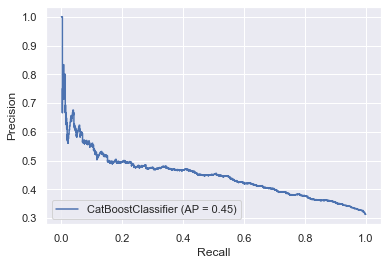

In [35]:
#без тюнинга 

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train, cat_features=cat_features)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(model_catb, X_test, y_train, y_train_pred, y_test, y_test_pred)

#### Подбор гиперпараметров

In [36]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [37]:
# %%time

# gscv = GridSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
# gscv.fit(X, y, cat_features=cat_features)

# gscv.best_params_

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.62      0.72      3771
           1       0.43      0.74      0.55      1479

    accuracy                           0.65      5250
   macro avg       0.64      0.68      0.63      5250
weighted avg       0.74      0.65      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      1616
           1       0.40      0.73      0.52       634

    accuracy                           0.62      2250
   macro avg       0.62      0.65      0.60      2250
weighted avg       0.72      0.62      0.64      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               927  689
1               173  461
CPU times: user 7.58 s, sys: 360 ms, total: 7.94 s
Wall time: 2.88 s


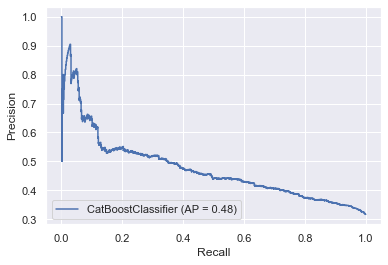

In [38]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21, l2_leaf_reg=1000, 
                                      auto_class_weights='Balanced', eta=0.08)

final_model.fit(X_train, y_train, cat_features=cat_features)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(final_model, X_test, y_train, y_train_pred, y_test, y_test_pred)

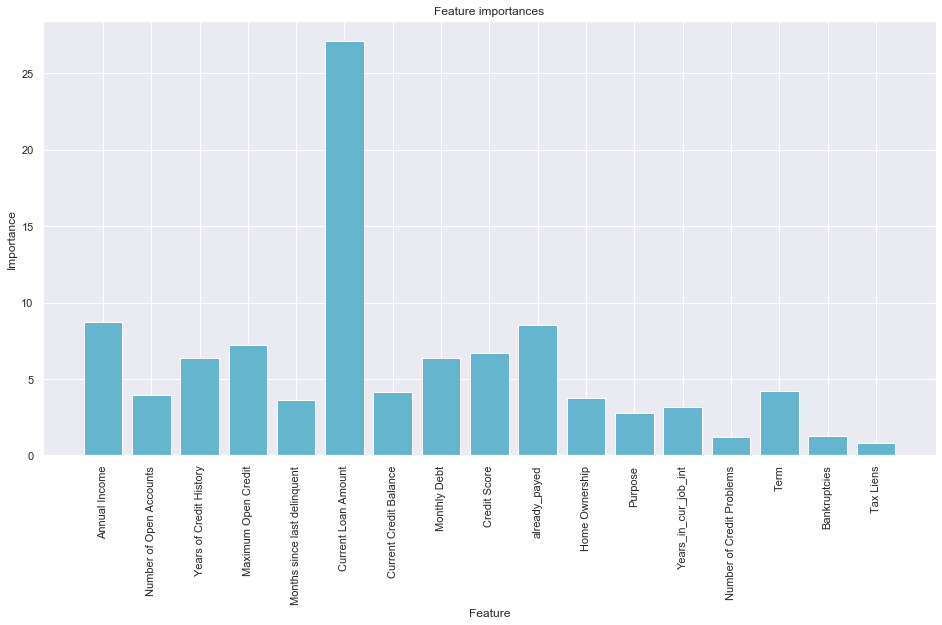

In [39]:
importances = model_catb.feature_importances_
plt.figure(figsize = [16, 8])
plt.bar(X.columns, importances, color='c')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.show()

In [40]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [41]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

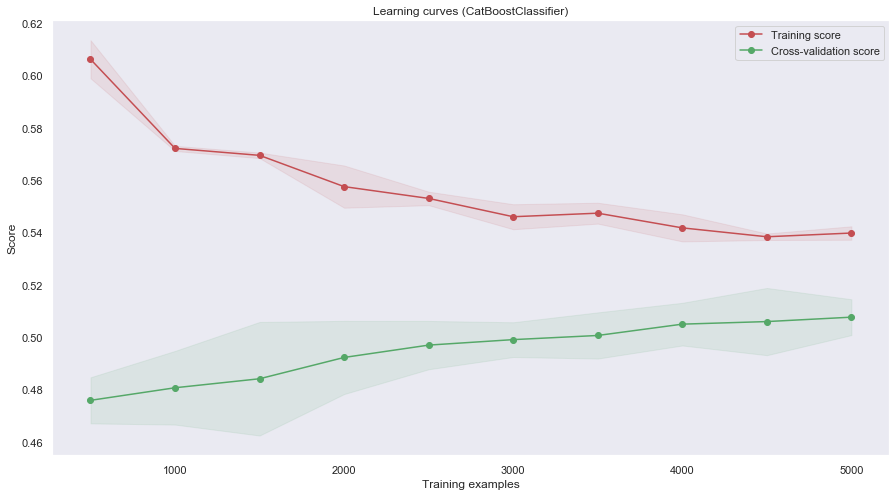

In [42]:
show_learning_curve_plot(final_model, X[num_feature_names], y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


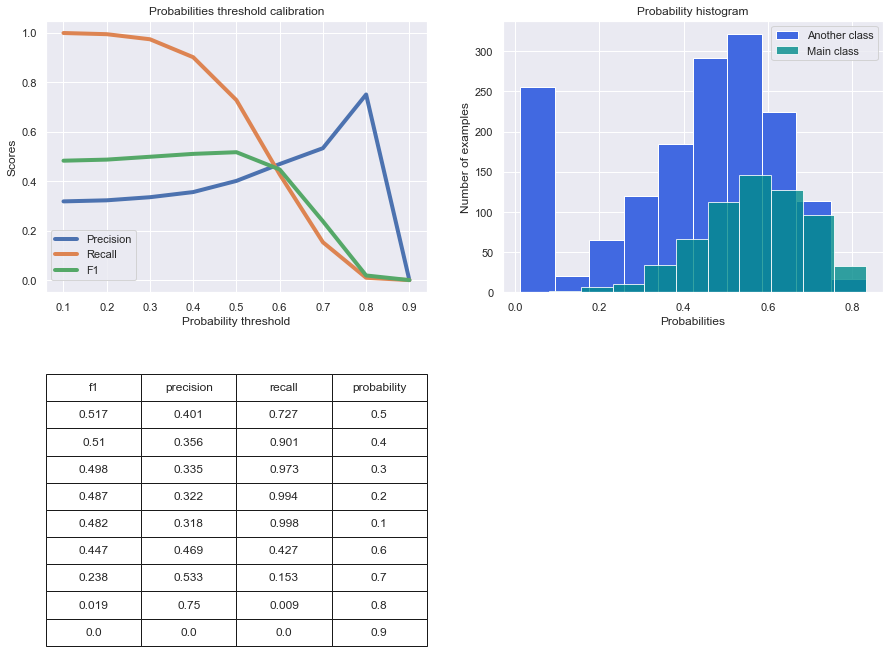

In [43]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### 9. Итоговое предсказание

In [44]:
df = pd.read_csv(train_path)
y = df[target_name]
X = df[df.columns.drop(target_name).tolist()]

X_final = pd.read_csv(test_path)
preds_final = pd.DataFrame()

In [45]:
# очищаем и преобразовываем финальный даатсет
imputer = FeatureImputer()
imputer.fit(X)
X = imputer.transform(X)
X_final = imputer.transform(X_final)

features = FeatureGenetator()
features.fit(X)
X = features.transform(X)
X_final = features.transform(X_final)

X_final = X_final[selected_feature_names]
X = X[selected_feature_names]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-22-3103d8b51ff6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Term'] = X['Term'].map(self.binary_to_numbers)


In [46]:
X['Home Ownership'] = X['Home Ownership'].astype(str)
X['Purpose'] = X['Purpose'].astype(str)
X['Years_in_cur_job_int'] = X['Years_in_cur_job_int'].astype(int)
X['Number of Credit Problems'] = X['Number of Credit Problems'].astype(int)
X['Term'] = X['Term'].astype(int)
X['Bankruptcies'] = X['Bankruptcies'].astype(int)
X['Tax Liens'] = X['Tax Liens'].astype(int)


X_final['Home Ownership'] = X_final['Home Ownership'].astype(str)
X_final['Purpose'] = X_final['Purpose'].astype(str)
X_final['Years_in_cur_job_int'] = X_final['Years_in_cur_job_int'].astype(int)
X_final['Number of Credit Problems'] = X_final['Number of Credit Problems'].astype(int)
X_final['Term'] = X_final['Term'].astype(int)
X_final['Bankruptcies'] = X_final['Bankruptcies'].astype(int)
X_final['Tax Liens'] = X_final['Tax Liens'].astype(int)


for colname in selected_cat_names:
    X[colname] = pd.Categorical(X[colname])
    X_final[colname] = pd.Categorical(X_final[colname])
    

In [47]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21, l2_leaf_reg=1000, 
                                      auto_class_weights='Balanced', eta=0.08)

final_model.fit(X, y, cat_features=cat_features)

In [48]:
y_test_pred_probs = final_model.predict_proba(X_final)

decisions = np.array(y_test_pred_probs[:,1] >= 0.59).astype(int)
preds_final['Credit Dafault'] = decisions
preds_final.to_csv('APlavina_predictions.csv')

preds_final['Credit Dafault'].value_counts()

0    1844
1     656
Name: Credit Dafault, dtype: int64

In [49]:
preds_final.head(5)

,Credit Dafault
0,0
1,1
2,0
3,0
4,0
